In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.io
from scipy.ndimage import binary_dilation, generate_binary_structure
from scipy.optimize import curve_fit
from utils import plot_jungfrau, combineRuns, get_tree, is_leaf, get_leaves, runNumToString, enable_underscore_cleanup, keV2Angstroms
enable_underscore_cleanup() # Sets ipython hook to delete user defined varibles that start with _ at the end of each cell execution

In [2]:
# (1) keys_to_combine: some keys loaded for each shot & stored per shot 
# (2) keys_to_sum: some keys loaded per each run and added 
# (3) keys_to_check : check if some keys exits and have same values in all runs and load these keys 
keys_to_combine = [#'gas_detector/f_11_ENRC',
                   #'ebeam/photon_energy',
                   'evr/code_183',
                   'evr/code_137',
                   'evr/code_141',
                   'lightStatus/xray',
                   #'jungfrau4M/Full_thres_sum',
                   #'feeBld/hproj',
                   'lightStatus/laser',
                   'ipm_dg2/sum',
                    #'qadc0',
                   'evr/code_195',
                   'ipm_dg2/sum',
                    #'alvium_usr/usr_com',
                    #'alvium_usr/usr_sum',
                    #'alvium_usr/usr_pj0_data',
                    #'alvium_usr/usr_pj1_data',
                    'alvium_u1/laser_downsample_data',
                    'alvium_u1/laser_sum',
                    'epicsAll/vernier'
                  ]

keys_to_sum = [#'Sums/jungfrau4M_calib'
                ]
#               'Sums/jungfrau4M_calib_thresADU1']

keys_to_check = [
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_q',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_q',
                # 'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_idxq',
                # 'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_idxq',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_q', # This are only needed once
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_phi', # This are only needed once
                #'UserDataCfg/jungfrau4M/x',
                #'UserDataCfg/jungfrau4M/y',
                #'UserDataCfg/jungfrau4M/z',
                #'UserDataCfg/jungfrau4M/cmask'
                ]
#xray_energy = _data['gas_detector/f_11_ENRC']   # xray energy from gas detector (not calibrated to actual values)
#xray_eV = _data['ebeam/photon_energy']    # x-ray energy energy in eV|
#spec = _data['feeBld/hproj'] # Shot to shot spectrometer

# New data!
#aoptCam = _data['alvium_usr/usr_pj0_data'] # All optical phase tagging (AOPT alvium horizontal projection shot by shot)

In [3]:
###############################################
# 37 - 5.185 keV
runNumbers = [122] # 14.6keV
folder = '/sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/'
###############################################
_data = combineRuns(runNumbers, folder, keys_to_combine, keys_to_sum, keys_to_check, verbose=False)  # this is the function to load the data with defined keys

xrayOn= _data['evr/code_137'].astype(bool)  # Every hard xray shot
xrayOn2 = _data['lightStatus/xray'].astype(bool)  # evt code 137
laserOn = _data['lightStatus/laser'].astype(bool)  # not(evt code 184) (Duck shots)
gasOn = _data['evr/code_195'].astype(bool) # Gas on events

run_indicator = _data['run_indicator'] # run indicator for each shot
downsampledImg = _data['alvium_u1/laser_downsample_data']
u1Sum = _data['alvium_u1/laser_sum']
ipm = _data['ipm_dg2/sum']
photon_energy = 14.45  # keV

Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cxi100895124_Run0122.h5
Loaded Data


(array([    0.,     0.,     0.,     0.,     0., 45515.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

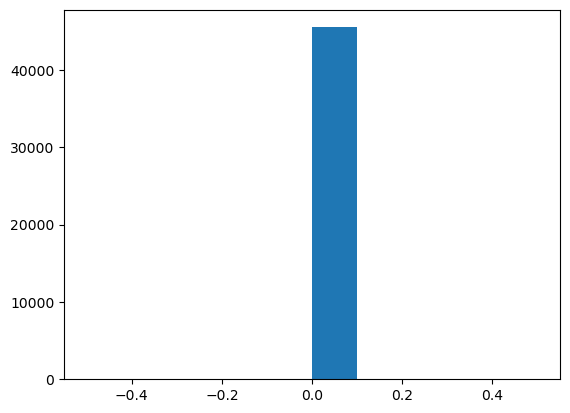

In [91]:
plt.hist(scan*1)

### Getting a background image from the gas off shots that had xrays on

(0.0, 125.0, 0.0, 125.0)

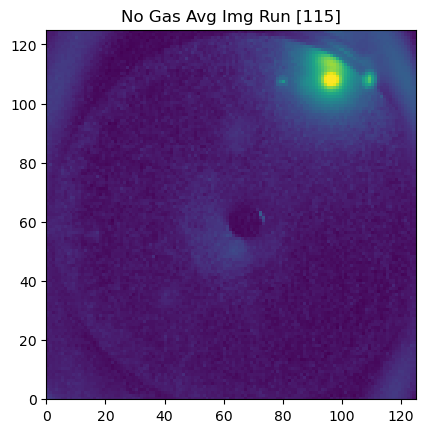

In [102]:
bkg = downsampledImg[(~gasOn*xrayOn*xrayOn2)].mean(axis=0)
plt.pcolor(bkg,norm=LogNorm())
plt.title(f'No Gas Avg Img Run {runNumbers}')
plt.axis('image')

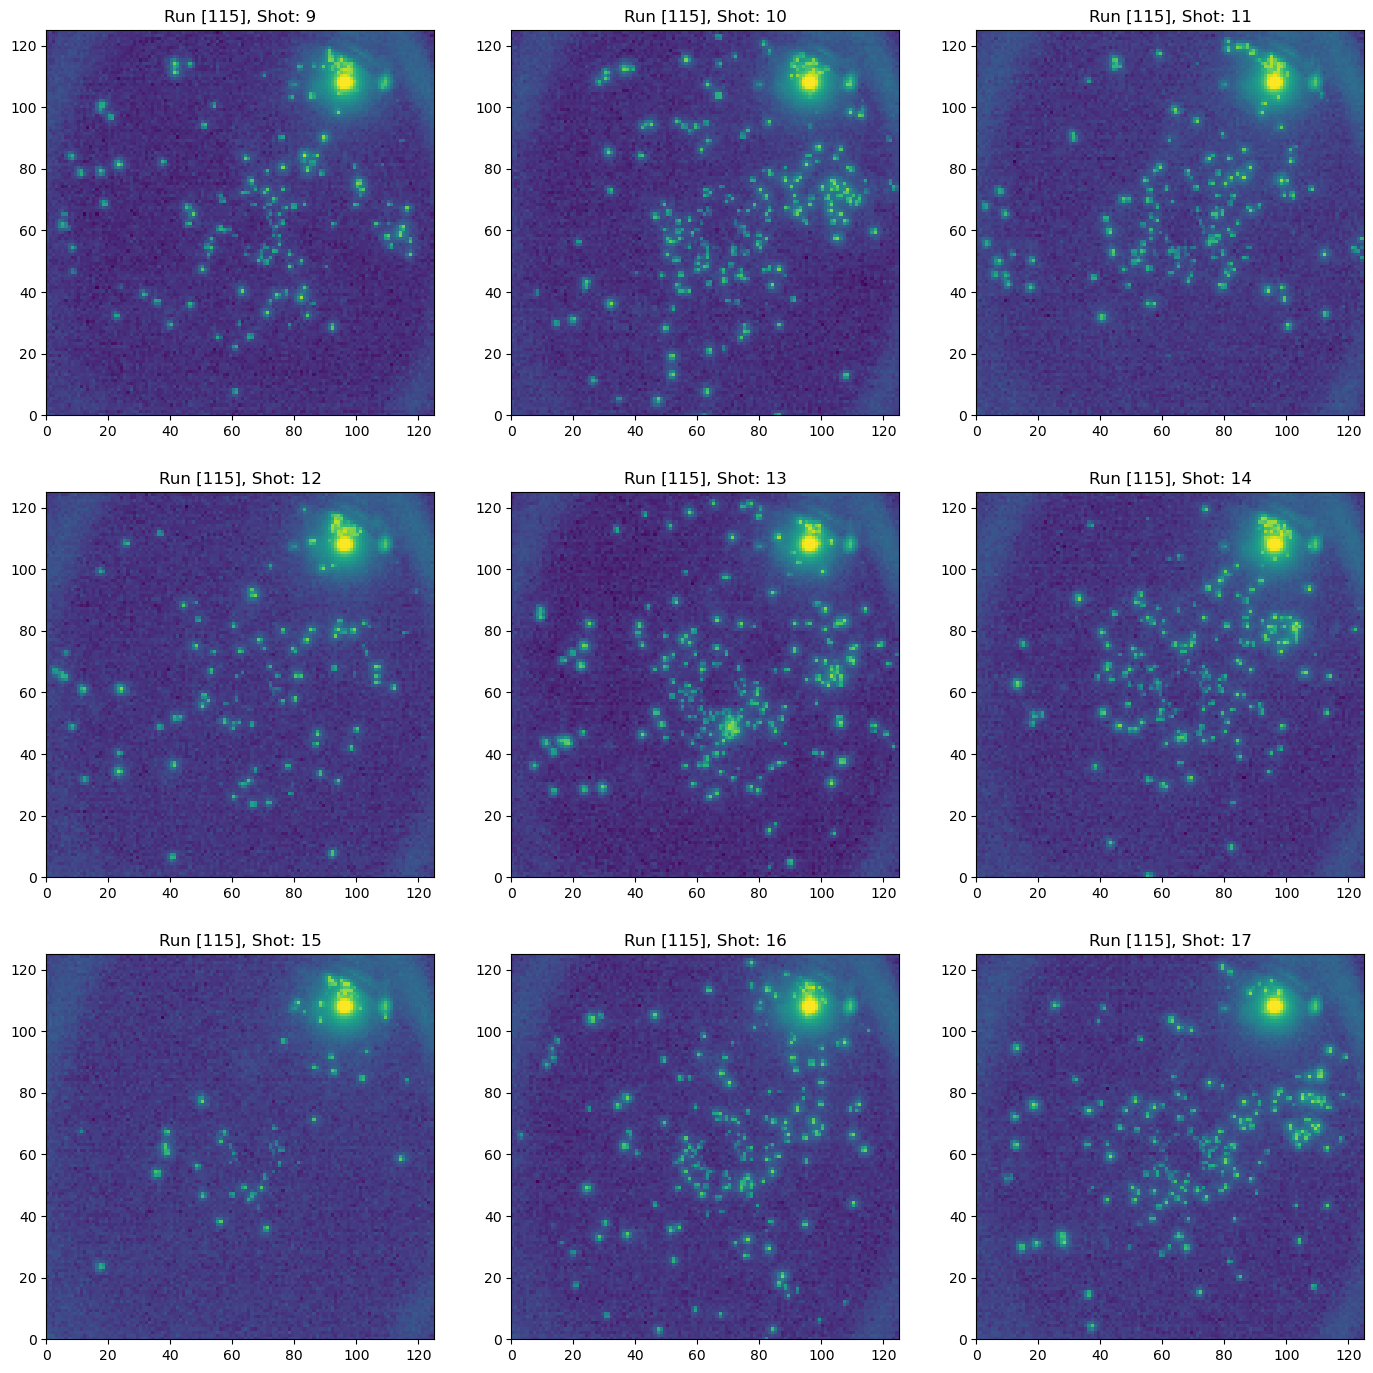

In [103]:
_bkg = (~gasOn*xrayOn*xrayOn2)
plt.figure(figsize=[17,17])
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.pcolor(downsampledImg[i+9],norm=LogNorm())
    plt.title(f'Run {runNumbers}, Shot: {i+9}')

Text(0.5, 1.0, 'Gas - No Gas Avg Img Run [115]')

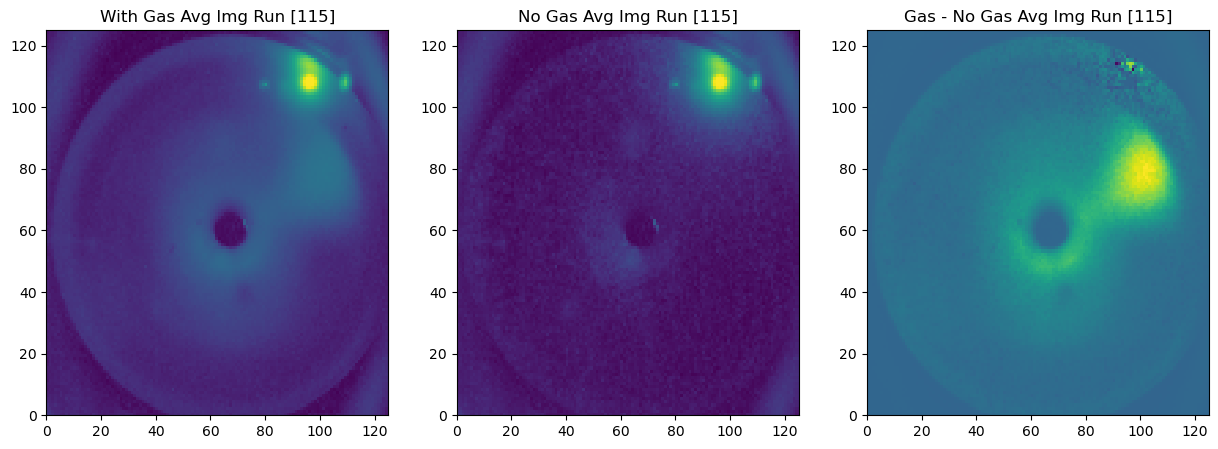

In [104]:
bkg = downsampledImg[(~gasOn*xrayOn*xrayOn2)].mean(axis=0)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.pcolor(downsampledImg[(gasOn*xrayOn*xrayOn2)].mean(axis=0),norm=LogNorm())
plt.title(f'With Gas Avg Img Run {runNumbers}')
plt.subplot(1,3,2)
plt.pcolor(bkg,norm=LogNorm())
plt.title(f'No Gas Avg Img Run {runNumbers}')
plt.subplot(1,3,3)
plt.pcolor(downsampledImg[(gasOn*xrayOn*xrayOn2)].mean(axis=0)-bkg)
plt.title(f'Gas - No Gas Avg Img Run {runNumbers}')

### Creating a mask for the u1 img

In [105]:
doMask = 0
if doMask:
    _meanImg = downsampledImg.mean(axis=0)
    _structure = generate_binary_structure(2, 1)  # 2D connectivity-1 (cross)
    mask = binary_dilation((_meanImg>=np.max(_meanImg)-1300),structure=_structure, iterations=3)
    plt.figure(figsize=[12,5])
    plt.subplot(1,2,1)
    plt.pcolor(_meanImg)
    plt.colorbar()
    plt.clim([0,400])
    plt.title(f'Unmasked Average, Run {runNumbers}')
    plt.subplot(1,2,2)
    _meanImg[mask == 1] = 0
    plt.pcolor(_meanImg)
    plt.title(f'Masked Average, Run {runNumbers}')
    plt.clim([0,400])
    plt.colorbar()
else:
    _meanImg = downsampledImg.mean(axis=0)
    mask = np.zeros_like(_meanImg)

### Filtering data based off of DG2 IPM Sum and U1 Sum

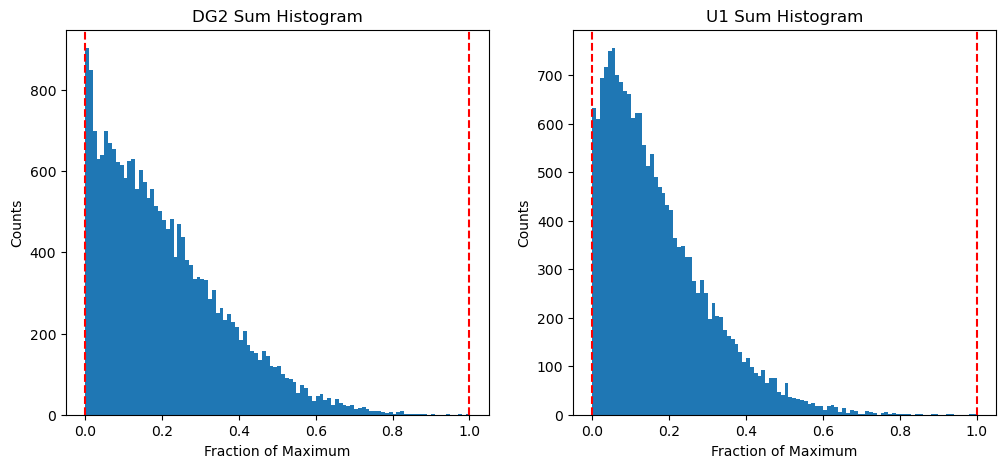

Good data represents 75.63% of the total shots. (17157 out of 22685).


In [106]:
########## Different filter cutoffs
_u1_cutoff = [0.0, 1];
_dg2_cutoff = [0.0, 1];
##########
if doMask:
    downsampledImg[:, mask == 1] = 0
else:
    downsampledImg = downsampledImg - bkg
u1Sum = downsampledImg.sum(axis=1).sum(axis=1); # Recalculating the sum without the bad portion
# Precomputing the normalized values
_u1Sum_norm = u1Sum/u1Sum.max();
_ipm_norm = ipm/np.nanmax(ipm);

plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.hist(_ipm_norm,bins=100,range=[0,1]);
plt.axvline(_dg2_cutoff[0],color='r',linestyle='--')
plt.axvline(_dg2_cutoff[1],color='r',linestyle='--')
#plt.yscale('log')
plt.title('DG2 Sum Histogram')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.hist(_u1Sum_norm,bins=100,range=[0,1]);
plt.axvline(_u1_cutoff[0],color='r',linestyle='--')
plt.axvline(_u1_cutoff[1],color='r',linestyle='--')
#plt.yscale('log')
plt.title('U1 Sum Histogram')
plt.xlabel('Fraction of Maximum')
plt.ylabel('Counts')

plt.show()
goodIdx = np.logical_and.reduce([
    xrayOn2,
    _u1_cutoff[0] <= _u1Sum_norm,
    _u1Sum_norm <= _u1_cutoff[1],
    _dg2_cutoff[0] <= _ipm_norm,
    _ipm_norm <= _dg2_cutoff[1],
    ~np.isnan(ipm),
    gasOn
])
u1Img = downsampledImg[goodIdx]
u1SumGood = u1Sum[goodIdx]
ipmGood = ipm[goodIdx]
# Displaying how much data was kept due to this filtering
_counts,_bins = np.histogram(goodIdx.astype(int),[0,1,2]);
print(f'Good data represents {_counts[1]/np.sum(_counts)*100:.2f}% of the total shots. ({_counts[1]} out of {np.sum(_counts)}).')

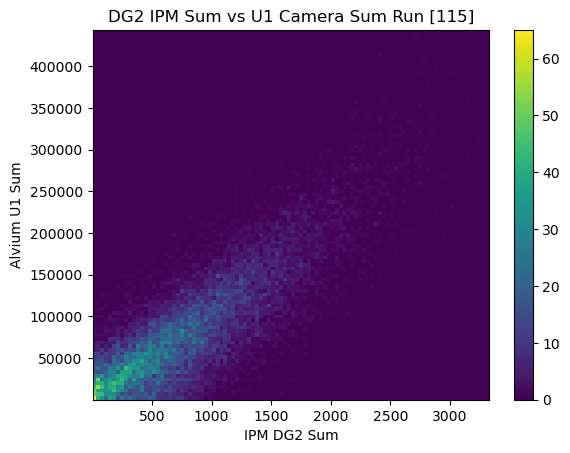

In [107]:
plt.hist2d(ipmGood,u1SumGood,bins=100);
plt.title(f'DG2 IPM Sum vs U1 Camera Sum Run {runNumbers}')
plt.xlabel('IPM DG2 Sum')
plt.ylabel('Alvium U1 Sum')
plt.colorbar()
plt.show();

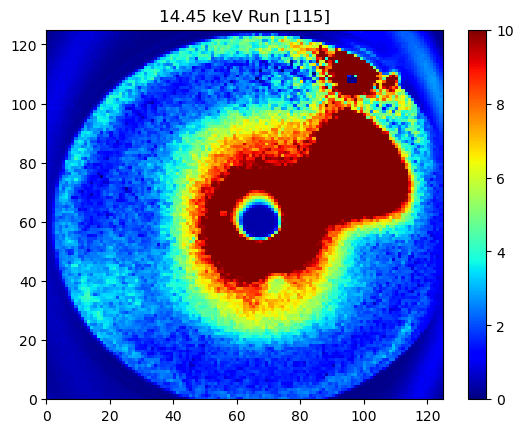

In [108]:
avgImg115 = u1Img.mean(axis=0)
plt.pcolor(avgImg115,cmap='jet')#,norm=LogNorm())
plt.title(f'{photon_energy} keV Run {runNumbers}')
plt.clim([0,10])
#plt.axvline(22,color='k')
#plt.axhline(15,color='k')
plt.colorbar()

Text(0.5, 1.0, '14.45 (R115 1 scale) - 14.4 (R113 1 scale)')

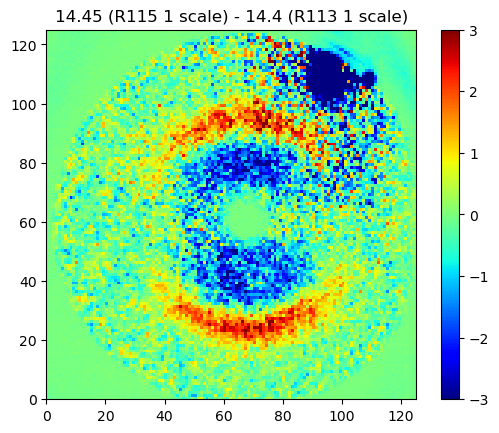

In [111]:
plt.pcolor(avgImg115-avgImg113,cmap='jet')
plt.axis('image')
plt.colorbar()
plt.clim([-3,3])
plt.title('14.45 (R115 1 scale) - 14.4 (R113 1 scale)')